# Извлечение признаков изображения, поиск по картинкам

Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
#pip install opencv-python

In [2]:
#pip install --upgrade pip

In [3]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Загружаем исходные данные

In [4]:
train = np.loadtxt('train 2.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test 2.csv', delimiter=',', skiprows=1)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [6]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

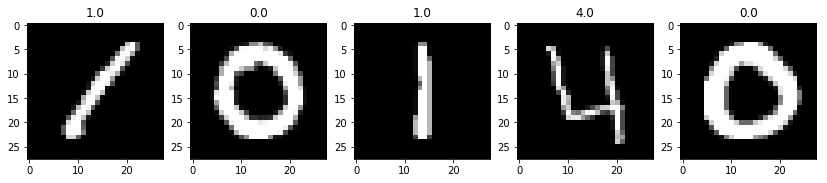

In [7]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [8]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [9]:

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [10]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [11]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

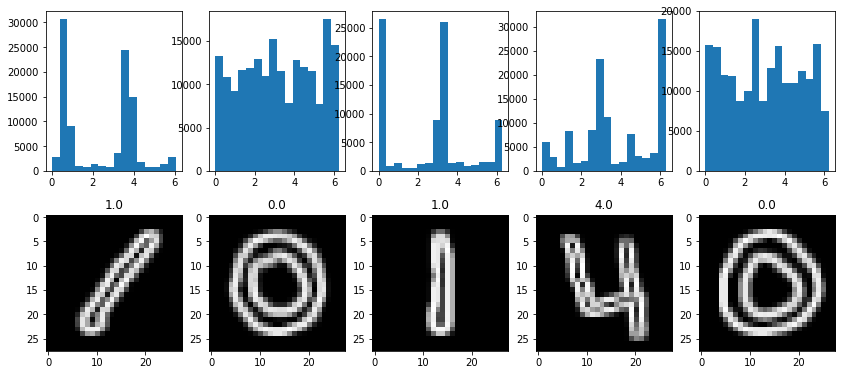

In [12]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [13]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [14]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [15]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [16]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [17]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

# 1. KNN 

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [19]:
params = {
    'n_neighbors':np.arange(1, 10)
}

gsearch = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1)
gsearch.fit(x_train, y_train)
n_neighbors_best = gsearch.best_params_['n_neighbors']

In [20]:
clf = KNeighborsClassifier(n_neighbors=n_neighbors_best)
clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

In [21]:
y_val_predict = clf.predict(x_val)

In [22]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_val_predict))

Accuracy: 0.6030952380952381


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_predict))

              precision    recall  f1-score   support

         0.0       0.33      0.49      0.40       816
         1.0       0.95      0.95      0.95       909
         2.0       0.44      0.38      0.40       846
         3.0       0.62      0.68      0.65       937
         4.0       0.68      0.68      0.68       839
         5.0       0.62      0.60      0.61       702
         6.0       0.42      0.38      0.40       785
         7.0       0.86      0.72      0.78       893
         8.0       0.51      0.46      0.48       835
         9.0       0.67      0.64      0.65       838

   micro avg       0.60      0.60      0.60      8400
   macro avg       0.61      0.60      0.60      8400
weighted avg       0.61      0.60      0.61      8400



In [24]:
pred_test = clf.predict(test_hist).astype(int)

In [25]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [26]:
!head submit.txt

ImageId,Label
1,3
2,3
3,9
4,0
5,3
6,7
7,0
8,3
9,3


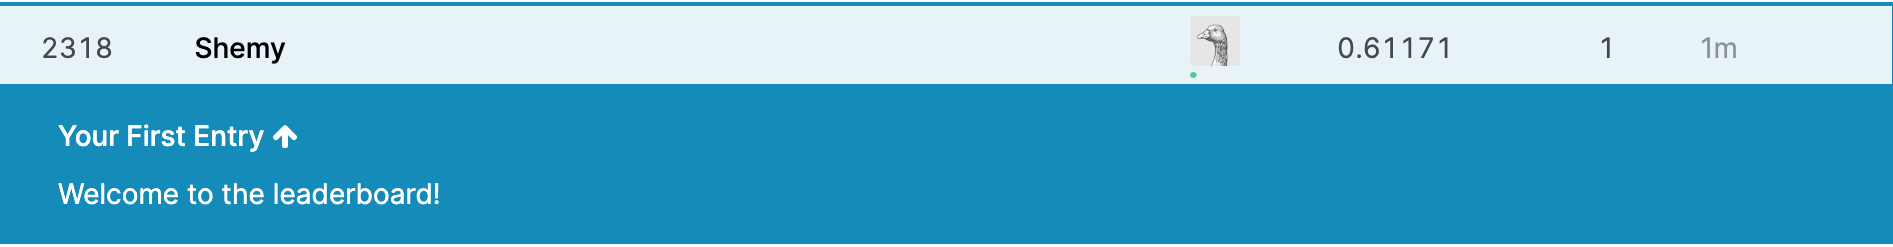

In [27]:
from IPython.display import Image
Image("shemy.png")

## Визуализируем предсказания

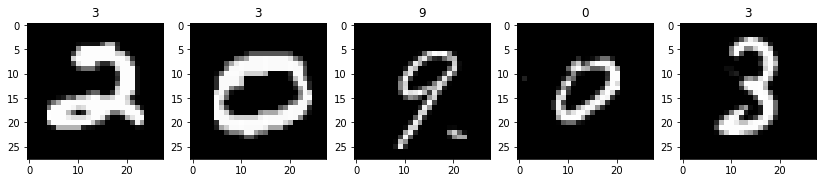

In [28]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

# 2. RandomForestClassifier    

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
params = {
    'max_depth':np.arange(1, 7)
}

gsearch = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1)
gsearch.fit(x_train, y_train)
max_depth_best = gsearch.best_params_['max_depth']

In [31]:
clf = RandomForestClassifier(
    max_depth=max_depth_best
)
clf.fit(x_train, y_train)
y_val_predict = clf.predict(x_val)

In [32]:
print('Accuracy: %s' % accuracy_score(y_val, y_val_predict))

Accuracy: 0.5384523809523809


In [33]:
print(classification_report(y_val, y_val_predict))

              precision    recall  f1-score   support

         0.0       0.35      0.13      0.19       816
         1.0       0.97      0.95      0.96       909
         2.0       0.37      0.21      0.27       846
         3.0       0.47      0.69      0.56       937
         4.0       0.60      0.60      0.60       839
         5.0       0.50      0.55      0.53       702
         6.0       0.32      0.44      0.37       785
         7.0       0.76      0.74      0.75       893
         8.0       0.41      0.48      0.44       835
         9.0       0.52      0.52      0.52       838

   micro avg       0.54      0.54      0.54      8400
   macro avg       0.53      0.53      0.52      8400
weighted avg       0.53      0.54      0.53      8400



In [34]:
pred_test = clf.predict(test_hist).astype(int)

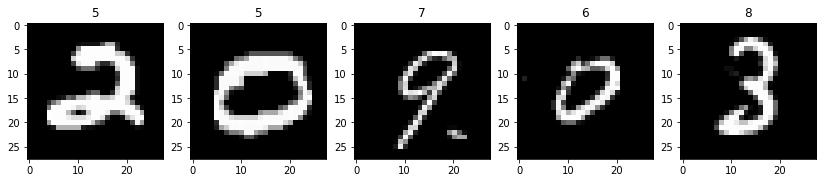

In [35]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

In [36]:
with open('submit_R.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

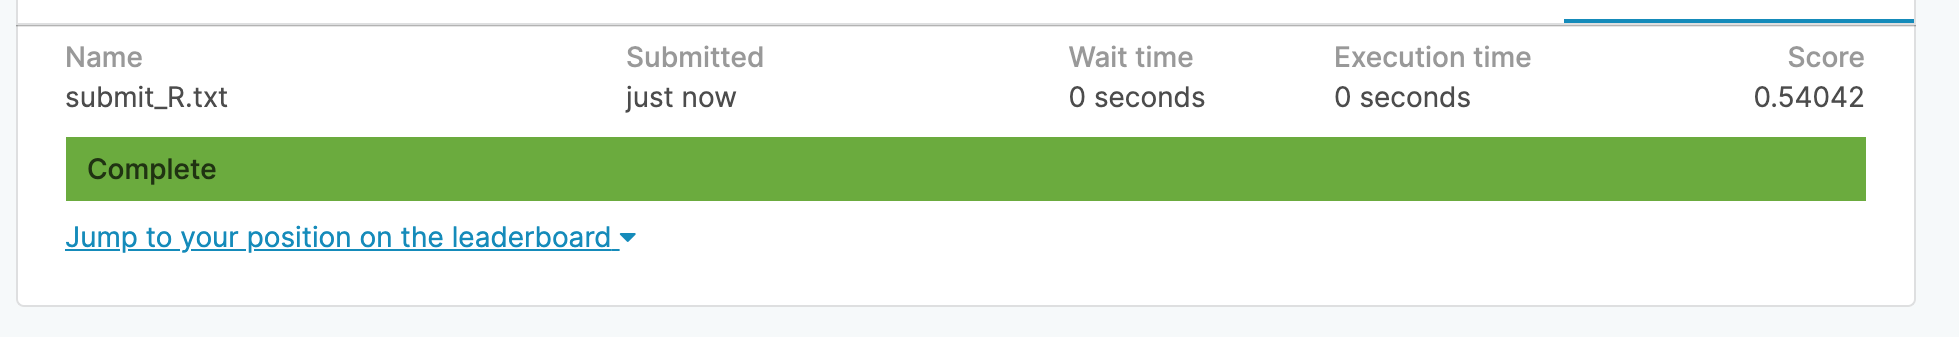

In [63]:
from IPython.display import Image
Image("RF.png")

# Посмотрим с PCA.

In [37]:
from sklearn.decomposition import PCA

###  возьмем  12 признаков

In [38]:
pca = PCA(n_components=12)
pca.fit_transform(x_train)

array([[ 2.07029719e-01,  1.64243868e-01,  1.41217113e-01, ...,
        -3.15128332e-05,  9.37929141e-02, -2.02160457e-02],
       [-3.58128931e-01, -3.42767373e-01,  7.54330315e-02, ...,
        -2.24489032e-02,  6.38597727e-03, -5.78240117e-02],
       [-4.28170638e-01, -2.69237227e-01, -8.59534028e-02, ...,
        -6.05189786e-02,  5.09668879e-03,  2.67584396e-02],
       ...,
       [-4.44389015e-01, -2.31398084e-01, -1.37363894e-01, ...,
        -6.69011047e-02, -8.50865499e-02,  2.01678582e-02],
       [-2.78062845e-01, -6.08437160e-02,  4.87738782e-03, ...,
         1.94876535e-01, -3.70122169e-02, -5.33335164e-02],
       [-1.98348756e-01, -1.76343710e-01, -1.04075264e-01, ...,
         8.74426248e-03, -2.12417190e-02, -6.75817810e-02]])

In [39]:
pca.fit(x_train)
pca.fit(train[:, :784])

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [40]:
X_train = pca.transform(train[:, :784])
X_test = pca.transform(test)

In [41]:
y_train, y_val, x_train, x_val = train_test_split(
    train_label, X_train, test_size=0.2,
    random_state=42)

# 1. KNN классификатор.

In [42]:
params = {
    'n_neighbors':np.arange(1, 10)
}

gsearch = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1)
gsearch.fit(x_train, y_train)
n_neighbors_best = gsearch.best_params_['n_neighbors']

In [43]:
clf = KNeighborsClassifier(n_neighbors=n_neighbors_best)
clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

In [44]:
y_val_predict = clf.predict(x_val)

In [45]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_val_predict))

Accuracy: 0.9416666666666667


In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_predict))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       816
         1.0       0.97      0.99      0.98       909
         2.0       0.96      0.95      0.96       846
         3.0       0.93      0.90      0.91       937
         4.0       0.93      0.93      0.93       839
         5.0       0.92      0.94      0.93       702
         6.0       0.95      0.98      0.96       785
         7.0       0.96      0.94      0.95       893
         8.0       0.92      0.91      0.92       835
         9.0       0.90      0.89      0.89       838

   micro avg       0.94      0.94      0.94      8400
   macro avg       0.94      0.94      0.94      8400
weighted avg       0.94      0.94      0.94      8400



In [47]:
pred_test = clf.predict(X_test).astype(int)

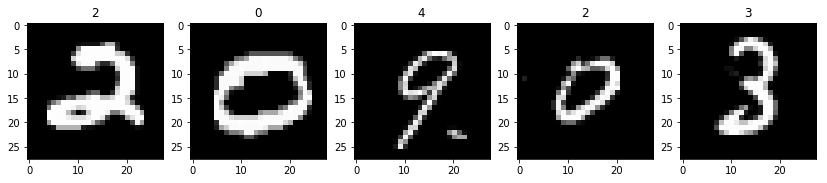

In [48]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

In [49]:
with open('submit_KNN.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

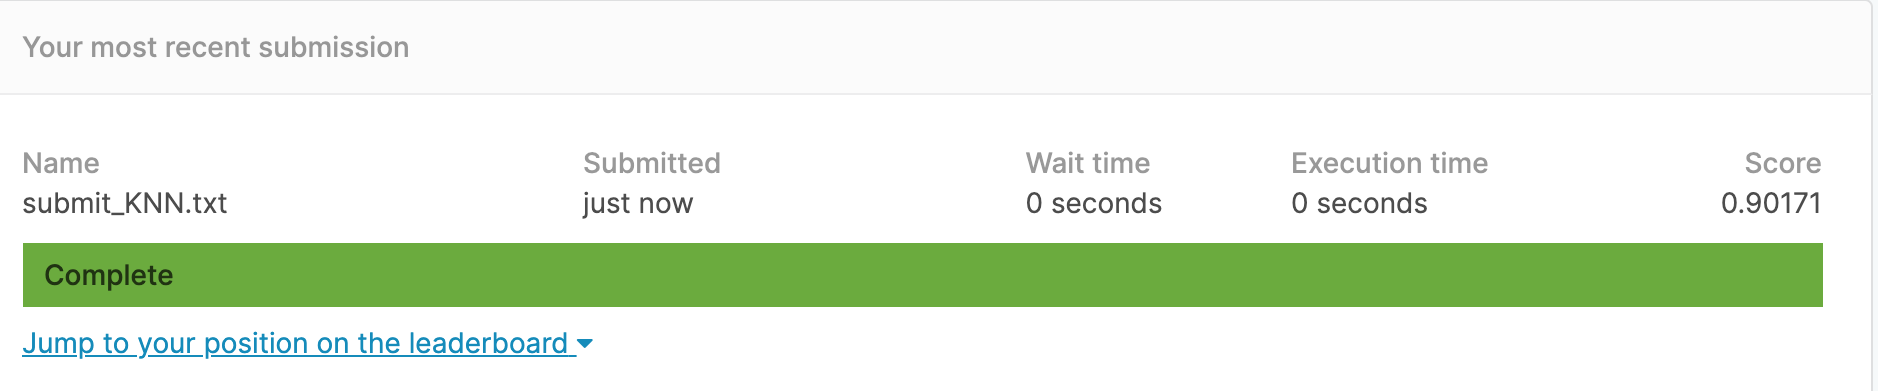

In [62]:
from IPython.display import Image
Image("KNN.png")

# 2. RandomForest .

In [50]:
params = {
    'max_depth':np.arange(1, 7)
}

gsearch = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1)
gsearch.fit(x_train, y_train)
max_depth_best = gsearch.best_params_['max_depth']

In [51]:
clf = RandomForestClassifier(
    max_depth=max_depth_best
)
clf.fit(x_train, y_train)
y_val_predict = clf.predict(x_val)

In [52]:
print('Accuracy: %s' % accuracy_score(y_val, y_val_predict))

Accuracy: 0.7730952380952381


In [53]:
print(classification_report(y_val, y_val_predict))

              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87       816
         1.0       0.86      0.94      0.90       909
         2.0       0.77      0.75      0.76       846
         3.0       0.68      0.81      0.74       937
         4.0       0.83      0.73      0.78       839
         5.0       0.69      0.49      0.57       702
         6.0       0.86      0.85      0.86       785
         7.0       0.83      0.84      0.84       893
         8.0       0.62      0.72      0.67       835
         9.0       0.70      0.69      0.69       838

   micro avg       0.77      0.77      0.77      8400
   macro avg       0.78      0.77      0.77      8400
weighted avg       0.78      0.77      0.77      8400



In [54]:
pred_test = clf.predict(X_test).astype(int)

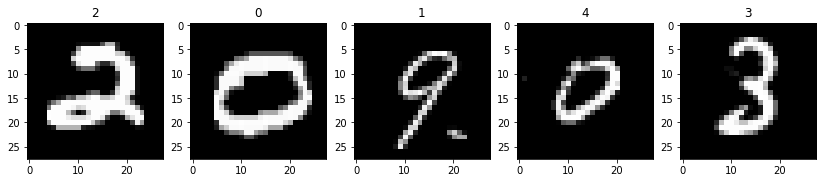

In [55]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

In [56]:
with open('submit_1.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [57]:
!head submit_1.txt

ImageId,Label
1,2
2,0
3,1
4,4
5,3
6,7
7,0
8,3
9,0


#   наилучший результат получается с использованием PCA и модели KNN.